## 0) Setup
Expected local artifact (from your bronze pipeline): `data/bronze/transactions.parquet`.
Minimum columns: `block_number`, `from`, `to`, `value`, `gas`, `gas_price` (wei).

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import matplotlib.pyplot as plt

DATA_DIR = Path("data")
TX_PARQUET = DATA_DIR / "bronze" / "transactions.parquet"

TOP_K_WALLETS = 2000  # adjust down if memory is tight
K_RANGE = range(2, 9)
RANDOM_STATE = 42

pd.set_option("display.max_columns", 200)


## 1) (Optional) Ingest from Alchemy (API-dependent)
If you already have `transactions.parquet`, **skip this**. This is a template.

In [2]:
import requests
ALCHEMY_URL = "https://eth-mainnet.g.alchemy.com/v2/0bNYASpyX5OXRJ-AEUOU_"

def rpc(method, params):
    payload = {"jsonrpc": "2.0", "id": 1, "method": method, "params": params}
    r = requests.post(ALCHEMY_URL, json=payload, timeout=60)
    r.raise_for_status()
    return r.json()["result"]

def get_block(block_number: int, full_tx: bool = True):
    return rpc("eth_getBlockByNumber", [hex(block_number), full_tx])



In [20]:
latest = int(rpc("eth_blockNumber", []), 16)
start = latest - 500
rows = []
for bn in range(start, latest + 1):
    b = get_block(bn, full_tx=True)
    for tx in b["transactions"]:
        rows.append({
            "block_number": int(tx["blockNumber"], 16) if isinstance(tx.get("blockNumber"), str) else bn,
            "from": tx.get("from"),
            "to": tx.get("to"),
            "value": int(tx.get("value", "0x0"), 16),
            "gas": int(tx.get("gas", "0x0"), 16),
            "gas_price": int(tx.get("gasPrice", "0x0"), 16),
        })

df = pd.DataFrame(rows)


## 2) Load Transactions (local)
If the Parquet is missing, this notebook generates a small synthetic dataset so it still runs end-to-end.

In [5]:
if TX_PARQUET.exists():
    tx = pd.read_parquet(TX_PARQUET)
    print("Loaded:", TX_PARQUET, "shape=", tx.shape)
else:
   tx = df

def _hex_to_int(x):
    if isinstance(x, str) and x.startswith("0x"):
        return int(x, 16)
    return x

# Normalize common Alchemy keys if present
if "blockNumber" in tx.columns and "block_number" not in tx.columns:
    tx["block_number"] = tx["blockNumber"].map(_hex_to_int)
if "gasPrice" in tx.columns and "gas_price" not in tx.columns:
    tx["gas_price"] = tx["gasPrice"].map(_hex_to_int)

for col in ["value", "gas", "gas_price"]:
    if col in tx.columns:
        tx[col] = tx[col].map(_hex_to_int)

for col in ["from", "to"]:
    tx[col] = tx[col].astype(str).str.lower()

tx = tx.dropna(subset=["block_number", "from", "to"])
tx.head()


,block_number,from,to,value,gas,gas_price
0,24531395,0x1af536507925d4d5eb82599385ea2b5aa2029c03,0xcd451547fb0eb1c0b2497da195401ea7ff8297b9,89203725567361930,21000,5000000000
1,24531395,0xec682362ef6143d0e03fac9e6a16d4690a390f76,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0,58746,4990870806
2,24531395,0xed141572d93b5a4d08c1b32cca1a0d3e168400a9,0x80a64c6d7f12c47b7c66c5b4e20e72bc1fcd5d9e,0,296635,3057324799
3,24531395,0xeac5956a7c97a536cda4d22a02d3509e13b2b32d,0x703c806e0a81287414245c0e9d466fc07d08365b,0,160041,2895092314
4,24531395,0x86c7b2171d91079d808469535a7ce1e6cb9e3725,0x28f2e7888bbff2f49e9842e1c6b37fedaff7364c,353310295927016790,90000,2169607300


## 3) Select Top Wallets
Compute features for the **top K wallets** by total participation (sent + received) in this window.

In [6]:
from_counts = tx["from"].value_counts()
to_counts = tx["to"].value_counts()
wallet_counts = (from_counts.add(to_counts, fill_value=0)).sort_values(ascending=False)

top_wallets = wallet_counts.head(TOP_K_WALLETS).index
tx_top = tx[tx["from"].isin(top_wallets) | tx["to"].isin(top_wallets)].copy()

print("Top wallets:", len(top_wallets))
print("Filtered tx:", tx_top.shape)


Top wallets: 2000
Filtered tx: (22644, 6)


## 4) Feature Engineering (15-feature schema)
Implements the feature categories described in the meeting report: activity, value flow, gas behavior, interactions.

In [7]:
WEI_PER_ETH = 10**18
tx_top["value_eth"] = tx_top["value"].astype(np.float64) / WEI_PER_ETH
tx_top["gas_price_gwei"] = tx_top["gas_price"].astype(np.float64) / 1e9

# Heuristic contract detection: frequent `to` addresses are likely contracts.
to_freq = tx_top["to"].value_counts()
CONTRACT_TO_THRESHOLD = max(100, int(to_freq.quantile(0.999)))
likely_contracts = set(to_freq[to_freq >= CONTRACT_TO_THRESHOLD].index)
tx_top["to_is_contract"] = tx_top["to"].isin(likely_contracts)

sent = tx_top.rename(columns={"from": "wallet", "to": "counterparty"}).copy()
sent["direction"] = "sent"

recv = tx_top.rename(columns={"to": "wallet", "from": "counterparty"}).copy()
recv["direction"] = "recv"

both = pd.concat([sent, recv], ignore_index=True)
g = both.groupby("wallet", sort=False)

# Activity
tx_count = g.size().rename("tx_count")
active_blocks = g["block_number"].nunique().rename("active_blocks")
tx_per_block = (tx_count / active_blocks.replace(0, np.nan)).fillna(0).rename("tx_per_block")

per_block_counts = both.groupby(["wallet", "block_number"]).size().rename("tx_in_block").reset_index()
burstiness = per_block_counts.groupby("wallet")["tx_in_block"].std(ddof=0).fillna(0).rename("burstiness")

# Value flow
sent_g = sent.groupby("wallet")
recv_g = recv.groupby("wallet")

eth_sent = sent_g["value_eth"].sum().rename("eth_sent")
eth_recv = recv_g["value_eth"].sum().rename("eth_recv")
eth_net_flow = (eth_recv.sub(eth_sent, fill_value=0)).rename("eth_net_flow")
avg_tx_value = g["value_eth"].mean().fillna(0).rename("avg_tx_value")

# Gas
avg_gas = g["gas"].mean().fillna(0).rename("avg_gas")
avg_gas_price_gwei = g["gas_price_gwei"].mean().fillna(0).rename("avg_gas_price_gwei")
both["gas_spent_eth"] = (both["gas"].astype(np.float64) * both["gas_price"].astype(np.float64)) / WEI_PER_ETH
total_gas_spent_eth = g["gas_spent_eth"].sum().fillna(0).rename("total_gas_spent_eth")

# Interactions
unique_counterparties = g["counterparty"].nunique().rename("unique_counterparties")
unique_contracts = sent[sent["to_is_contract"]].groupby("wallet")["counterparty"].nunique().rename("unique_contracts").reindex(top_wallets, fill_value=0)
contract_interaction_rate = sent.groupby("wallet")["to_is_contract"].mean().rename("contract_interaction_rate").reindex(top_wallets, fill_value=0)

cp_counts = both.groupby(["wallet", "counterparty"]).size().rename("cp_tx").reset_index()
cp_total = cp_counts.groupby("wallet")["cp_tx"].sum()
cp_counts["p"] = cp_counts.apply(lambda r: r["cp_tx"] / cp_total.loc[r["wallet"]], axis=1)
counterparty_concentration = cp_counts.groupby("wallet")["p"].apply(lambda p: float(np.sum(p.values**2))).rename("counterparty_concentration")

features = pd.concat([
    tx_count.reindex(top_wallets, fill_value=0),
    active_blocks.reindex(top_wallets, fill_value=0),
    tx_per_block.reindex(top_wallets, fill_value=0),
    burstiness.reindex(top_wallets, fill_value=0),
    eth_sent.reindex(top_wallets, fill_value=0),
    eth_recv.reindex(top_wallets, fill_value=0),
    eth_net_flow.reindex(top_wallets, fill_value=0),
    avg_tx_value.reindex(top_wallets, fill_value=0),
    avg_gas.reindex(top_wallets, fill_value=0),
    avg_gas_price_gwei.reindex(top_wallets, fill_value=0),
    total_gas_spent_eth.reindex(top_wallets, fill_value=0),
    unique_counterparties.reindex(top_wallets, fill_value=0),
    unique_contracts.reindex(top_wallets, fill_value=0),
    contract_interaction_rate.reindex(top_wallets, fill_value=0),
    counterparty_concentration.reindex(top_wallets, fill_value=0),
], axis=1).reset_index().rename(columns={"index": "wallet"})

print("Feature matrix:", features.shape)
features.head()


Feature matrix: (2000, 16)


,wallet,tx_count,active_blocks,tx_per_block,burstiness,eth_sent,eth_recv,eth_net_flow,avg_tx_value,avg_gas,avg_gas_price_gwei,total_gas_spent_eth,unique_counterparties,unique_contracts,contract_interaction_rate,counterparty_concentration
0,0xecc2d7c17bfca3f7ce08f3646d92651ad5ef0e2e,4326,62,69.774194,111.842259,0.000000,2.658412e-02,2.658412e-02,6.145196e-06,21001.202034,0.045401,0.004125,4320,0,0.0,0.000232
1,0xdac17f958d2ee523a2206206994597c13d831ec7,3236,100,32.360000,20.424750,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,107876.217244,0.571493,0.198476,2335,0,0.0,0.005589
2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,1465,98,14.948980,10.911866,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,86187.482594,0.485516,0.060048,1160,0,0.0,0.002249
3,0x94edfd9728fa1eb571f5e5776bcb32dbac97b751,395,88,4.488636,3.965746,0.003188,7.085659e-04,-2.479720e-03,9.865447e-06,119879.741772,0.072865,0.004375,301,0,0.0,0.059766
4,0xfbd4cdb413e45a52e2c8312f670e9ce67e794c37,322,85,3.788235,2.430658,0.000000,7.874594e-09,7.874594e-09,2.445526e-11,515795.055901,1.680371,2.248501,22,0,0.0,0.068053


## 5) Preprocess (log1p + robust scaling)
Heavy-tailed nonnegative features are log-transformed, then scaled. `eth_net_flow` can be negative and is only scaled.

In [8]:
nonneg_cols = [
    "tx_count","active_blocks","tx_per_block","burstiness",
    "eth_sent","eth_recv","avg_tx_value",
    "avg_gas","avg_gas_price_gwei","total_gas_spent_eth",
    "unique_counterparties","unique_contracts","counterparty_concentration"
]

df = features.copy()
for c in nonneg_cols:
    df[c] = np.log1p(df[c].clip(lower=0))

X = df.drop(columns=["wallet"]).astype(np.float64).values
scaler = RobustScaler()
Xs = scaler.fit_transform(X)

feature_names = df.drop(columns=["wallet"]).columns.tolist()


## 6) Cluster + pick k by silhouette

In [9]:
sils = []
models = []
for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    labels = km.fit_predict(Xs)
    sils.append(silhouette_score(Xs, labels))
    models.append(km)

best_idx = int(np.argmax(sils))
best_k = list(K_RANGE)[best_idx]
best_km = models[best_idx]
cluster = best_km.predict(Xs)

print("Silhouette by k:", dict(zip(list(K_RANGE), [round(s, 3) for s in sils])))
print("Selected k =", best_k, "silhouette =", round(sils[best_idx], 3))


Silhouette by k: {2: 0.997, 3: 0.995, 4: 0.986, 5: 0.977, 6: 0.978, 7: 0.953, 8: 0.951}
Selected k = 2 silhouette = 0.997


## 7) 2D projection: LDA (separable) vs PCA (baseline)
LDA uses `cluster_id` as pseudo-labels to explicitly find a linear projection that best separates the clusters.

In [18]:
n_classes = len(np.unique(cluster))
n_components = min(2, n_classes - 1)
if n_components < 1:
    raise RuntimeError("Need at least 2 clusters for LDA.")

lda = LinearDiscriminantAnalysis(n_components=n_components)
X_lda = lda.fit_transform(Xs, cluster)
if X_lda.shape[1] == 1:
    X_lda = np.column_stack([X_lda[:, 0], np.zeros(len(X_lda))])

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(Xs)

print("PCA explained variance:", pca.explained_variance_ratio_.round(3))


PCA explained variance: [1. 0.]


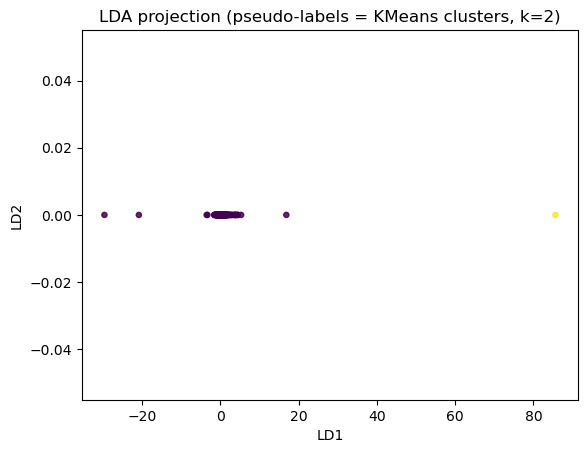

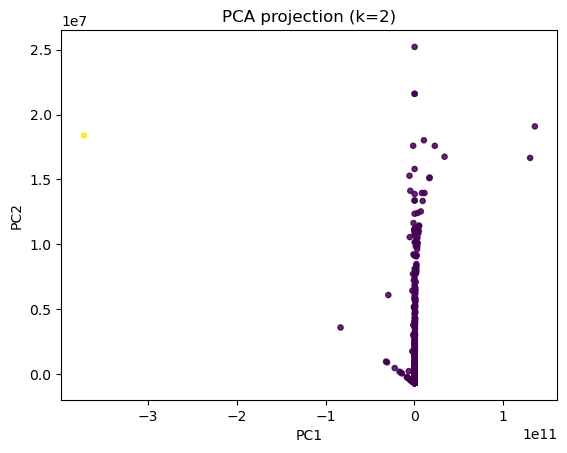

In [19]:
plt.figure()
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=cluster, s=14, alpha=0.85)
plt.title(f"LDA projection (pseudo-labels = KMeans clusters, k={best_k})")
plt.xlabel("LD1"); plt.ylabel("LD2")
plt.show()

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster, s=14, alpha=0.85)
plt.title(f"PCA projection (k={best_k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


## 8) Cluster profiling (for human-readable labels)
Use medians to interpret each cluster and assign dashboard labels like `whale-like`, `bot-like`, `router`, etc.

In [14]:
profile = df.copy()
profile["cluster_id"] = cluster

cluster_medians = profile.groupby("cluster_id").median(numeric_only=True)
cluster_sizes = profile["cluster_id"].value_counts().sort_index().rename("n_wallets")

display(pd.concat([cluster_sizes, cluster_medians], axis=1))


,n_wallets,tx_count,active_blocks,tx_per_block,burstiness,eth_sent,eth_recv,eth_net_flow,avg_tx_value,avg_gas,avg_gas_price_gwei,total_gas_spent_eth,unique_counterparties,unique_contracts,contract_interaction_rate,counterparty_concentration
cluster_id,,,,,,,,,,,,,,,,
0,1999,1.791759,1.791759,0.693147,0.0,0.000000,0.0,0.0,5.500000e-10,11.246157,0.070063,0.000093,1.386294,0.0,0.0,0.318454
1,1,1.945910,1.945910,0.693147,0.0,7.720018,0.0,-2252.0,5.930475e+00,12.076809,0.715106,0.001099,1.791759,0.0,0.0,0.200671


## 9) (Optional) True contract detection via `eth_getCode` (API-dependent)
Replaces the frequency heuristic with an on-chain contract check.

In [15]:
# =========================
# API-DEPENDENT (Alchemy)
# =========================
# import requests
# ALCHEMY_URL = "https://eth-mainnet.g.alchemy.com/v2/YOUR_API_KEY"
#
# def eth_getCode(address: str, block: str = "latest"):
#     payload = {"jsonrpc": "2.0", "id": 1, "method": "eth_getCode", "params": [address, block]}
#     r = requests.post(ALCHEMY_URL, json=payload, timeout=30)
#     r.raise_for_status()
#     return r.json()["result"]  # "0x" => EOA, else => contract bytecode


## 10) Save artifacts
Writes `data/gold/wallet_features_with_clusters.parquet` for your dashboard.

In [ ]:
OUT_DIR = Path("data") / "gold"
OUT_DIR.mkdir(parents=True, exist_ok=True)

out_df = features.copy()
out_df["cluster_id"] = cluster
out_df["ld1"] = X_lda[:, 0]
out_df["ld2"] = X_lda[:, 1]
out_df["pc1"] = X_pca[:, 0]
out_df["pc2"] = X_pca[:, 1]

out_path = OUT_DIR / "wallet_features_with_clusters.parquet"
out_df.to_parquet(out_path, index=False)
print("Wrote:", out_path, "shape=", out_df.shape)
